In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from pydrake.all import (
    DiagramBuilder,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    SceneGraph,
    Simulator,
    Meshcat,
    StartMeshcat,
    namedview,
)
from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController
import numpy as np

running_as_notebook = True
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# LQR

In [9]:
from pydrake.all import DiagramBuilder
from control.UtilLeafSystems import NonConstantVectorSource

from control.QuadrotorControllers import QuadrotorLQR
from sim.Quadrotor import MakeMultibodyQuadrotor, QuadrotorGeometry
from maths.quaternions import SampleQuaternion
from IPython.display import SVG, display, clear_output, Markdown
import pydot
import time 


Q = np.diag(np.concatenate(([10] * 6, [1] * 6)))
R = np.eye(4)

builder = DiagramBuilder()

# Init Systems
quadrotor, mbp = MakeMultibodyQuadrotor(show_diagram=False)
quadrotor_system = builder.AddSystem(quadrotor)
controller = builder.AddSystem(QuadrotorLQR(quadrotor_system, mbp, Q, R))
goal_state_source = builder.AddSystem(NonConstantVectorSource(13))
ref_action_source = builder.AddSystem(NonConstantVectorSource(4))

# Controller input connections
builder.Connect(
    quadrotor_system.get_output_port(), controller.get_input_port(0)
)
builder.Connect(
    goal_state_source.get_output_port(), controller.get_input_port(1)
)
builder.Connect(
    ref_action_source.get_output_port(), controller.get_input_port(2)
)

# Controller output connections
builder.Connect(
    controller.get_output_port(), quadrotor_system.get_input_port()
)

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
quadrotor_geometry_system = QuadrotorGeometry.AddToBuilder(
    builder, quadrotor_system.get_output_port(0), scene_graph
)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty("/Background", "visible", False)
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
# display(SVG(pydot.graph_from_dot_data(
#             diagram.GetGraphvizString(max_depth=1))[0].create_svg()))

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
diagram_context = simulator.get_mutable_context()

# Get the subsystem contexts
quadrotor_context = quadrotor_system.GetMyContextFromRoot(diagram_context)
controller_context = controller.GetMyContextFromRoot(diagram_context)
geometry_context = diagram.GetSubsystemContext(quadrotor_geometry_system, diagram_context)

# Function to print the state vector
def dynamically_update_output(state, control):
    clear_output(wait=True)
    display(Markdown(f"**State:**\n```\n{state}\n```\n**Control:**\n```\n{control}\n```"))

def log_state():
    quadrotor_state_port = quadrotor_system.get_output_port(0)
    control_output_port = controller.get_output_port(0)

    quadrotor_state = quadrotor_state_port.Eval(quadrotor_context)
    control = control_output_port.Eval(controller_context)
    
    dynamically_update_output(quadrotor_state, control)
    
    if np.any(np.isnan(quadrotor_state)):
        raise ValueError("Quadrotor state contains NaN values")

    if np.any(np.isnan(control)):
        raise ValueError("Control input contains NaN values")

def inspect_base_link_state(context, plant):
    inspector = plant.GetMyContextFromRoot(context)
    base_link_frame = plant.GetFrameByName('base_link')
    pose = plant.CalcRelativeTransform(inspector, plant.world_frame(), base_link_frame)
    print(f"Base Link Pose:\n{pose}")

def simulate(diagram_context, initial_state, ref_state, ref_action, duration):
    diagram_context.SetTime(0.0)
    diagram_context.SetContinuousState(initial_state)
    goal_state_source.SetState(ref_state)
    ref_action_source.SetState(ref_action) 
    simulator.Initialize()
    try:
        while diagram_context.get_time() < duration:
            # log_state()

            # Force evaluation of output port to see the state in QuadrotorGeometry
            # quadrotor_geometry_output: FramePoseVector = diagram.GetSubsystemByName('QuadrotorGeometry').get_output_port(0).Eval(geometry_context)
            # quadrotor_geometry_pose = quadrotor_geometry_output.value(quadrotor_geometry_output.ids()[0])

            # position_np = np.array(quadrotor_geometry_pose.translation())
            # rotation_np = np.array(quadrotor_geometry_pose.rotation().matrix())
            # print(f"Pose (Position):\n{position_np}")
            # print(f"Pose (Rotation):\n{rotation_np}")

            # inspect_base_link_state(diagram_context, mbp)

            simulator.AdvanceTo(diagram_context.get_time() + 0.1)
    except ValueError as e:
        print(f"Simulation error: {e}")

# initial_state = np.array([1., 0., 0., 0., 0., 0., 1.5, 0., 0., 0., 0., 0., 0.])
initial_state = np.hstack(
    (SampleQuaternion(near_identity=True),
    np.array([1., 0., 0., 0., 0., 0., 0., 0., 0.])
    )
)

ref_state = np.array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
gravity = mbp.gravity_field().gravity_vector()[2]
ref_action = np.array([-controller.mass * gravity / 4 for i in range(4)] )
print(ref_action)
simulate(diagram_context, initial_state, ref_state, ref_action, duration = 4.0)

[1.9006875 1.9006875 1.9006875 1.9006875]


# iLQR

### With Euler Angles

In [ ]:
from pydrake.all import DiagramBuilder
from pydrake.examples import QuadrotorGeometry as QuadrotorGeometry_EA

from control.QuadrotorControllers import QuadrotoriLQR_EA
from control.UtilLeafSystems import NonConstantVectorSource

from sim.Quadrotor import MakeMultibodyQuadrotor_EA
from maths.quaternions import SampleQuaternion
from IPython.display import SVG, display, clear_output, Markdown
np.set_printoptions(linewidth=500)

Q = np.diag(np.concatenate(([1.] * 6, [1.] * 6)))
R = np.diag([0.1] * 4)

builder = DiagramBuilder()

# Init Systems
quadrotor, mbp = MakeMultibodyQuadrotor_EA(show_diagram = False)
quadrotor_system = builder.AddSystem(quadrotor)

# print(mbp.GetStateNames())

iLQRparams = {
    "quadrotor" : quadrotor_system,
    "multibody_plant" : mbp,
    "Q" : np.diag(np.concatenate(([1.] * 6, [1.] * 6))),
    "R" : 0.1* np.eye(4),
    "Qf" : np.diag(np.concatenate(([1.] * 6, [1.] * 6))),
    "Tf" : 0.25,
    "dt" : 0.01,
    "max_iters" : 10,
    "init_regu" : 0.1,
}

controller = builder.AddSystem(QuadrotoriLQR_EA(**iLQRparams))
goal_state_source = builder.AddSystem(NonConstantVectorSource(12))


# Controller input connections
builder.Connect(
    quadrotor_system.get_output_port(), controller.get_input_port(0)
)
builder.Connect(
    goal_state_source.get_output_port(), controller.get_input_port(1)
)


# Controller output connections
builder.Connect(
    controller.get_output_port(), quadrotor_system.get_input_port()
)

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
quadrotor_geometry_system = QuadrotorGeometry_EA.AddToBuilder(
    builder, quadrotor_system.get_output_port(0), scene_graph
)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty("/Background", "visible", False)
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
# display(SVG(pydot.graph_from_dot_data(
#             diagram.GetGraphvizString(max_depth=1))[0].create_svg()))

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
diagram_context = simulator.get_mutable_context()

# Get the subsystem contexts
quadrotor_context = quadrotor_system.GetMyContextFromRoot(diagram_context)
controller_context = controller.GetMyContextFromRoot(diagram_context)
geometry_context = diagram.GetSubsystemContext(quadrotor_geometry_system, diagram_context)

# Function to print the state vector
def dynamically_update_output(state, control, time):
    clear_output(wait=True)
    display(Markdown(f"**Time:**\n```\n{time}\n```**State:**\n```\n{state}\n```\n**Control:**\n```\n{control}\n```"))

def log_state(time):
    quadrotor_state_port = quadrotor_system.get_output_port(0)
    control_output_port = controller.get_output_port(0)

    quadrotor_state = quadrotor_state_port.Eval(quadrotor_context)
    control = control_output_port.Eval(controller_context)
    
    dynamically_update_output(quadrotor_state, control, time)
    
    if np.any(np.isnan(quadrotor_state)):
        raise ValueError("Quadrotor state contains NaN values")

    if np.any(np.isnan(control)):
        raise ValueError("Control input contains NaN values")

def inspect_base_link_state(context, plant):
    inspector = plant.GetMyContextFromRoot(context)
    base_link_frame = plant.GetFrameByName('base_link')
    pose = plant.CalcRelativeTransform(inspector, plant.world_frame(), base_link_frame)
    print(f"Base Link Pose:\n{pose}")

def simulate(diagram_context, initial_state, ref_state, duration):
    diagram_context.SetTime(0.0)
    diagram_context.SetContinuousState(initial_state)
    goal_state_source.SetState(ref_state)
    simulator.Initialize()
    try:
        while diagram_context.get_time() < duration:
            # log_state(diagram_context.get_time())
            simulator.AdvanceTo(diagram_context.get_time() + iLQRparams["dt"])
    except ValueError as e:
        print(f"Simulation error: {e}")

# initial_state = np.array([1., 0., 0., 0., 0., 0., 1.5, 0., 0., 0., 0., 0., 0.])
initial_state = np.hstack(
    (np.array([0., 0., 2.]),
     .5* np.random.randn(3),
    np.array([0., 0., 0., 0., 0., 0.])
    )
)
ref_state = np.array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
simulate(diagram_context, initial_state, ref_state, duration = 4.0)

### With Quaternions

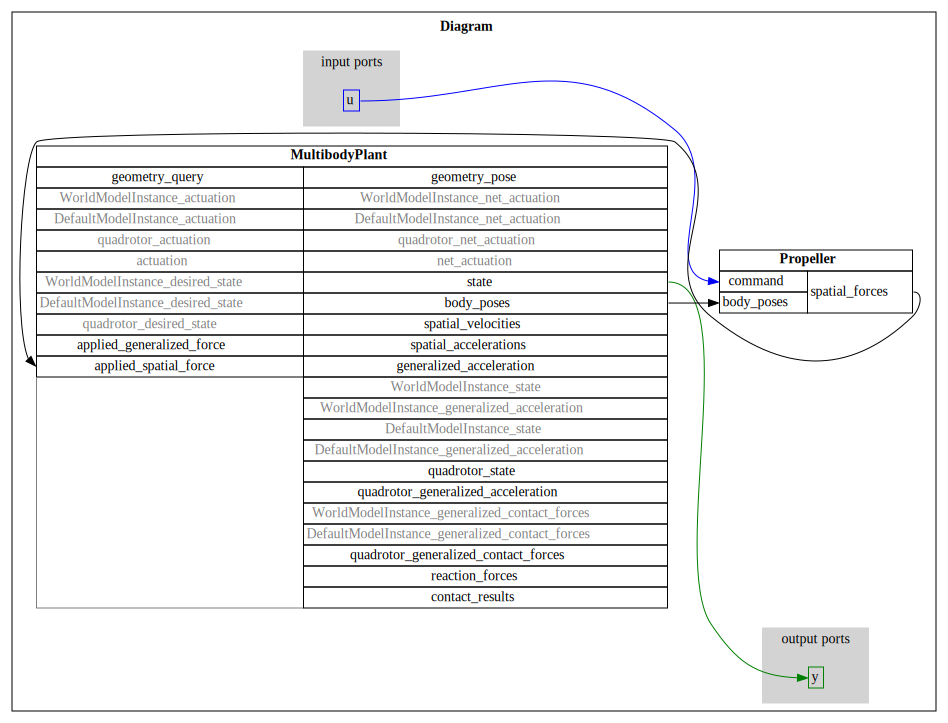

ZeroDivisionError: division by zero

In [9]:
from pydrake.all import DiagramBuilder, FramePoseVector

from control.QuadrotorControllers import QuadrotoriLQR
from control.UtilLeafSystems import NonConstantVectorSource

from sim.Quadrotor import MakeMultibodyQuadrotor, QuadrotorGeometry
from maths.quaternions import SampleQuaternion
from IPython.display import SVG, display, clear_output, Markdown
np.set_printoptions(linewidth=500)

Q = np.diag(np.concatenate(([1.] * 6, [1.] * 6)))
R = np.diag([0.1] * 4)

builder = DiagramBuilder()

# Init Systems
quadrotor, mbp = MakeMultibodyQuadrotor(show_diagram=True)
quadrotor_system = builder.AddSystem(quadrotor)
0/0
# print(mbp.GetStateNames())

iLQRparams = {
    "quadrotor" : quadrotor_system,
    "multibody_plant" : mbp,
    "Q" : np.diag(np.concatenate(([1.] * 6, [1.] * 6))),
    "R" : 0.1* np.eye(4),
    "Qf" : np.diag(np.concatenate(([1.] * 6, [1.] * 6))),
    "Tf" : 0.25,
    "dt" : 0.01,
    "max_iters" : 5,
    "init_regu" : 0.1,
}

controller = builder.AddSystem(QuadrotoriLQR(**iLQRparams))
goal_state_source = builder.AddSystem(NonConstantVectorSource(13))


# Controller input connections
builder.Connect(
    quadrotor_system.get_output_port(), controller.get_input_port(0)
)
builder.Connect(
    goal_state_source.get_output_port(), controller.get_input_port(1)
)


# Controller output connections
builder.Connect(
    controller.get_output_port(), quadrotor_system.get_input_port()
)

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
quadrotor_geometry_system = QuadrotorGeometry.AddToBuilder(
    builder, quadrotor_system.get_output_port(0), scene_graph
)
meshcat.Delete()
meshcat.ResetRenderMode()
meshcat.SetProperty("/Background", "visible", False)
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
# display(SVG(pydot.graph_from_dot_data(
#             diagram.GetGraphvizString(max_depth=1))[0].create_svg()))

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
diagram_context = simulator.get_mutable_context()

# Get the subsystem contexts
quadrotor_context = quadrotor_system.GetMyContextFromRoot(diagram_context)
controller_context = controller.GetMyContextFromRoot(diagram_context)
geometry_context = diagram.GetSubsystemContext(quadrotor_geometry_system, diagram_context)

# Function to print the state vector
def dynamically_update_output(state, control, time):
    clear_output(wait=True)
    display(Markdown(f"**Time:**\n```\n{time}\n```**State:**\n```\n{state}\n```\n**Control:**\n```\n{control}\n```"))

def log_state(time):
    quadrotor_state_port = quadrotor_system.get_output_port(0)
    control_output_port = controller.get_output_port(0)

    quadrotor_state = quadrotor_state_port.Eval(quadrotor_context)
    control = control_output_port.Eval(controller_context)
    
    dynamically_update_output(quadrotor_state, control, time)
    
    if np.any(np.isnan(quadrotor_state)):
        raise ValueError("Quadrotor state contains NaN values")

    if np.any(np.isnan(control)):
        raise ValueError("Control input contains NaN values")

def inspect_base_link_state(context, plant):
    inspector = plant.GetMyContextFromRoot(context)
    base_link_frame = plant.GetFrameByName('base_link')
    pose = plant.CalcRelativeTransform(inspector, plant.world_frame(), base_link_frame)
    print(f"Base Link Pose:\n{pose}")

def simulate(diagram_context, initial_state, ref_state, duration):
    diagram_context.SetTime(0.0)
    diagram_context.SetContinuousState(initial_state)
    goal_state_source.SetState(ref_state)
    simulator.Initialize()
    try:
        while diagram_context.get_time() < duration:
            # log_state(diagram_context.get_time())
            simulator.AdvanceTo(diagram_context.get_time() + 0.1)
    except ValueError as e:
        print(f"Simulation error: {e}")

# initial_state = np.array([1., 0., 0., 0., 0., 0., 1.5, 0., 0., 0., 0., 0., 0.])
initial_state = np.hstack(
    (SampleQuaternion(near_identity=True),
    np.array([1., 0., 0., 0., 0., 0., 0., 0., 0.])
    )
)
ref_state = np.array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
simulate(diagram_context, initial_state, ref_state, duration = 4.0)